
# Bank Customer Churn Prediction - Summary

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import os

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# # scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# # Over-sampling using SMOTE
# from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn import tree

import xgboost as xgb

import joblib
from tensorflow.keras.models import load_model
# Keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.models import Sequential


In [2]:
# If you are runnig "Dark Reader" on Chrome,install "jupyterthemes 
#  and run these lines so the legends and axes become visible
## from jupyterthemes import jtplot
## jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# To reset default matplotlib rcParams
## jtplot.reset()


## Load Analytical Base Table

In [2]:
df = pd.read_csv(os.path.join("Resources", "analytical_base_table.csv"))
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Separate dataframe into separate object

In [3]:
# Object for target variable
y = df.Exited

# object for input features
X = df.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


## Create a Train Test Split

In [4]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                   stratify=df.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [14]:
# Get a Numpy representation of the DataFrame
X_train = X_train.values
X_test = X_test.values

## Load Saved Models

In [5]:
dt_model = joblib.load('models/nate_decision_tree.sav')
dl_model = joblib.load('models/scikeras.sav')
##knn_model = joblib.load('models/nate_knn.sav')
lr_model = joblib.load('models/nate_logistic_regression.sav')
rf_model = joblib.load('models/nate_random_forest.sav')
svm_model = joblib.load('models/SVM_model.sav')
xgb_model = joblib.load('models/XGBoost_model.sav')


**Dictionary `'models'`**

We are going to create the dictionary `models` with names of all models. We will be using it later for plotting and displaying results of the models.

In [6]:
# Create models dictionary, it will be needed for ploting
models = {
    'dt' : 'Decision Tree',
    'dl': 'Deep Learning',
    #'knn' : 'K-nearest Neighbors',
    'lr' : 'Logistic Regression',
    'rf' : 'Random Forest',
    'svm' : 'Support Vector Machine (SVM)',
    'xgb' : 'XGBoost'
}

**Dictionary `'loaded_models'`**

The dictionary `loaded_models` with names of all loaded models. We will be using it later for plotting and displaying results of the models.

In [7]:
# Dictionary of all loaded models
loaded_models = {
    'dt' : dt_model,
    'dl': dl_model,
    #'knn': knn_model,
    'lr' : lr_model,
    'rf' : rf_model,
    'svm' : svm_model,
    'xgb' : xgb_model
}

'target_names' variable will be used later for printing evaluation results.

In [8]:
target_names = ['Stays', 'Exits']

### Helper Functions

**The function for creating the dataframe with evaluation metrics for each model.**

<pre>input: loaded models dictionary
output: evaluation metrics dataframe</pre>

In [9]:
def evaluation(fit_models):
    lst = []
    for name, model in fit_models.items():
        pred = model.predict(X_test)
        lst.append([name, 
                    precision_score(y_test, pred, average='macro'),
                    recall_score(y_test, pred, average='macro'),
                    f1_score(y_test, pred, average='macro'),
                    accuracy_score(y_test, pred)])

    eval_df = pd.DataFrame(lst, columns=['model', 'precision', 'recall', 'f1_macro', 'accuracy'])
    eval_df.set_index('model', inplace = True)
    return eval_df

**The helper function for displaying confusion matrix and classification report.**

<pre>input: loaded models dictionary, models dictionary and a dictionary key for one of the models
output: confusion matrix dataframe and classification report</pre>

In [10]:
def class_rep_cm(fit_models, models, model_id):
    # Predict classes using model_id
    pred = fit_models[model_id].predict(X_test)
    print()
    print('\t', models[model_id])
    print('\t', '='*len(models[model_id]))

    # Display confusion matrix for y_test and pred
    conf_df = pd.DataFrame(confusion_matrix(y_test, pred), columns=target_names, index=target_names)
    conf_df.index.name = 'True Labels'
    conf_df = conf_df.rename_axis('Predicted Labels', axis='columns')
    display(conf_df)
    
    # Display classification report
    print()
    print(classification_report(y_test, pred, target_names=target_names))


**The function for ploting one model's confusion matrix heatmaps without and with normalization.**

<pre>input: loaded models dictionary, models dictionary and dictionary key for one model, colormap for heatmaps
output: plot of two heatmaps</pre> 

In [11]:
def plot_conf_mat_w_and_wo_norm(fit_models, models, model_id, color):
    # Plot confusion matrix heatmaps
    pred = fit_models[model_id].predict(X_test)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.suptitle(models[model_id], fontsize=14)
    f.subplots_adjust(top=0.85, wspace=0.3)

    # confusion matrix without normalization
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='d',
                cbar=True,
                square=True,
                cmap=color,
                ax=ax1)

    ax1.set_xticklabels(labels=target_names)
    ax1.set_yticklabels(labels=target_names, va='center')
    ax1.set_title('Confusion Matrix w/o Normalization')
    ax1.set_xlabel('Predicted Label', size=12)
    ax1.set_ylabel('True Label', size=12)

    # normalized confusion matrix
    matn = mat / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matn,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='.2f',
                cbar=True,
                square=True,
                cmap=color,
                vmin = 0,
                vmax = 1,
                ax=ax2)

    ax2.set_xticklabels(labels=target_names)
    ax2.set_yticklabels(labels=target_names, va='center')
    ax2.set_title('Normalized Confusion Matrix')
    ax2.set_xlabel('Predicted Label', size=12)
    ax2.set_ylabel('True Label', size=12)

    plt.show()

**The helper function for ploting heatmaps for normalized confusion matrices for all models.**

<pre>input: loaded models dictionary, models dictionary and colormap for heatmaps
output: plot of heatmaps for each model</pre>

In [12]:
def plot_norm_conf_matrices(fit_models, models, color):
    # Prepare lists of coordinates for axes
    lt = []  # list for full subplots
    ltd = []  # list for empty subplots
    col = 2  # number of columns
    n_mod = len(fit_models)  # number of fitted models
    
    # Number of rows
    row = - (n_mod // -col)
    
    # Create lists of coordinates for full and empty subplots
    for r in range(row):
        for c in range(col):
            if n_mod >= (r + 1) * (c + 1):
                lt.append([r, c])
            else:
                ltd.append([r, c])
    
    # Create figure and subplots
    figs_y = row * 4  # y size
    f, axs = plt.subplots(row, col, figsize=(10, figs_y))
    f.suptitle('Normalized Confusion Matrices', fontsize=14)
    f.subplots_adjust(top=0.94, wspace=0.90, hspace=0.2)
    
    # Reshape axes; needed in case of only 1 row
    axs = axs.reshape(row,-col)

    # Loop to delete N last empty subplots (if any)
    for n in range(len(ltd)):
        r = ltd[n][0]
        c = ltd[n][1]
        f.delaxes(ax= axs[r, c])
        
    # Loop to plot all full subplots
    i = 0
    # Loop for each fitted model        
    for id, model in fit_models.items():
        pred = model.predict(X_test)
        name = models[id]
        r = lt[i][0]
        c = lt[i][1]
        i += 1
     
        mat = confusion_matrix(y_test, pred)    
        # normalized confusion matrix
        matn = mat / mat.sum(axis=1)[:, np.newaxis]

        ax = axs[r, c]
        sns.heatmap(matn,
                    annot=True,
                    annot_kws=dict(fontsize=14),
                    fmt='.2f',
                    cbar=False,
                    square=True,
                    cmap=color,
                    vmin = 0,
                    vmax = 1,
                    #cbar_kws = {'shrink' : 0.85},
                    ax=ax)
    
        ax.set_xticklabels(labels=target_names)
        ax.set_yticklabels(labels=target_names, va='center')
        ax.set_title(name)
        ax.set_xlabel('Predicted Label', size=12)
        ax.set_ylabel('True Label', size=12)

    plt.show()

### Display evaluation metrics

In [15]:
# Display evaluation metrics
evaluation(loaded_models)

,precision,recall,f1_macro,accuracy
model,,,,
dt,0.705436,0.752161,0.721427,0.797333
dl,0.674098,0.754000,0.678814,0.733333
lr,0.636816,0.695442,0.639900,0.707000
rf,0.750844,0.756587,0.753637,0.838333
svm,0.695592,0.764136,0.711246,0.775667
xgb,0.777935,0.752207,0.763716,0.853667


During cross-validation we were trying two scorers, f1_macro and accuracy, and then used a model that had better recal for true positive ("Exits"). 

### Display confusion matrix and classification report 

In [16]:
# Display classification report and confusion matrix for all models

for model in models.keys():
    class_rep_cm(loaded_models, models, model)


	 Decision Tree


Predicted Labels,Stays,Exits
True Labels,,
Stays,1979,410
Exits,198,413



              precision    recall  f1-score   support

       Stays       0.91      0.83      0.87      2389
       Exits       0.50      0.68      0.58       611

    accuracy                           0.80      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.80      0.81      3000


	 Deep Learning


Predicted Labels,Stays,Exits
True Labels,,
Stays,1718,671
Exits,129,482



              precision    recall  f1-score   support

       Stays       0.93      0.72      0.81      2389
       Exits       0.42      0.79      0.55       611

    accuracy                           0.73      3000
   macro avg       0.67      0.75      0.68      3000
weighted avg       0.83      0.73      0.76      3000


	 Logistic Regression


Predicted Labels,Stays,Exits
True Labels,,
Stays,1708,681
Exits,198,413



              precision    recall  f1-score   support

       Stays       0.90      0.71      0.80      2389
       Exits       0.38      0.68      0.48       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000


	 Random Forest


Predicted Labels,Stays,Exits
True Labels,,
Stays,2137,252
Exits,233,378



              precision    recall  f1-score   support

       Stays       0.90      0.89      0.90      2389
       Exits       0.60      0.62      0.61       611

    accuracy                           0.84      3000
   macro avg       0.75      0.76      0.75      3000
weighted avg       0.84      0.84      0.84      3000


	 Support Vector Machine (SVM)


Predicted Labels,Stays,Exits
True Labels,,
Stays,1872,517
Exits,156,455



              precision    recall  f1-score   support

       Stays       0.92      0.78      0.85      2389
       Exits       0.47      0.74      0.57       611

    accuracy                           0.78      3000
   macro avg       0.70      0.76      0.71      3000
weighted avg       0.83      0.78      0.79      3000


	 XGBoost


Predicted Labels,Stays,Exits
True Labels,,
Stays,2206,183
Exits,256,355



              precision    recall  f1-score   support

       Stays       0.90      0.92      0.91      2389
       Exits       0.66      0.58      0.62       611

    accuracy                           0.85      3000
   macro avg       0.78      0.75      0.76      3000
weighted avg       0.85      0.85      0.85      3000



### Plot normalized confusion matrix heatmaps for all loaded models

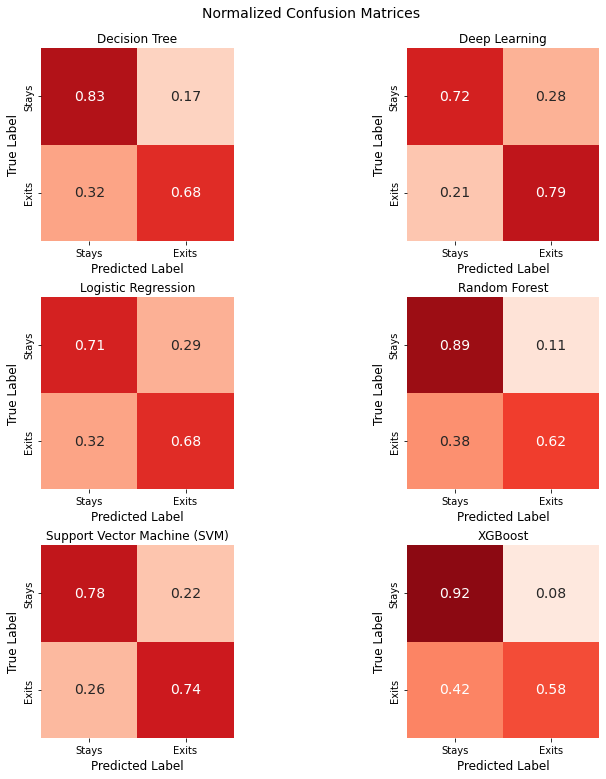

In [17]:
# Plot all confusion matrices 
plot_norm_conf_matrices(loaded_models, models, 'Reds')

From the above heatmaps we can see that Deep Learning and SVM are behaving the best. We have pretty leveled predictions for both, true negatives ("Stays") and true positives ("Exits"). 

## Impact of SMOTE to SVM model results

In our project we used of SMOTE to handle issues with the imbalanced data.

SMOTE (Synthetic Minority Over-sampling Technique) is an over-sampling method that creates new (synthetic) samples based on the samples in our minority classes. It finds the k-nearest-neighbors of each member of the minority classes.

The new samples should be generated only in the training set to ensure our model generalizes well to unseen data. We used [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) python package.

We will now show what impact SMOTE had to results of our SVM model.

In [18]:
# Load SVM models, one without and one with SMOTE
svm_model_nos = joblib.load('models/SVM_model_nos.sav')
svm_model_s = joblib.load('models/SVM_model_s.sav')

In [19]:
# Create SVM models dictionary, to be needed for ploting
models_svm = {
    'svm_nos' : 'SVM - without SMOTE',
    'svm_s' : 'SVM - with SMOTE'
}

In [20]:
# Dictionary of both SVM models
loaded_models_svm = {
    'svm_nos' : svm_model_nos,
    'svm_s' : svm_model_s
}

### Confusion matrix and classification report

Let's look first at confusion matrix and cclassification report for both models.

In [21]:
# Display classification report and confusion matrix for both SVM models

for model in models_svm.keys():
    class_rep_cm(loaded_models_svm, models_svm, model)


	 SVM - without SMOTE


Predicted Labels,Stays,Exits
True Labels,,
Stays,2311,78
Exits,328,283



              precision    recall  f1-score   support

       Stays       0.88      0.97      0.92      2389
       Exits       0.78      0.46      0.58       611

    accuracy                           0.86      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.86      0.85      3000


	 SVM - with SMOTE


Predicted Labels,Stays,Exits
True Labels,,
Stays,1872,517
Exits,156,455



              precision    recall  f1-score   support

       Stays       0.92      0.78      0.85      2389
       Exits       0.47      0.74      0.57       611

    accuracy                           0.78      3000
   macro avg       0.70      0.76      0.71      3000
weighted avg       0.83      0.78      0.79      3000



It is obvious that using SMOTE give us much better recall results what is a general goal for customer churning tasks.

Next, we will look at heatmaps of confusion matrices. It is a nice visaul tool to compare efficiency of models.

On the left side we will display confusion matrix and on the right side normalized confusion matrix. We want to show that for imbalanced data, confusion matrix without normalization is very deceiving.

### No SMOTE

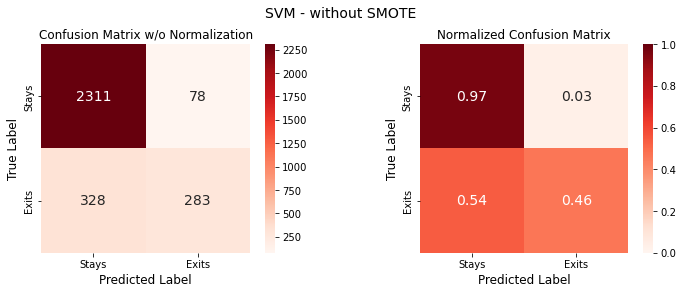

In [22]:
# Plot confusion matrix and its normalized version.
plot_conf_mat_w_and_wo_norm(loaded_models_svm, models_svm, 'svm_nos', 'Reds')

### With SMOTE

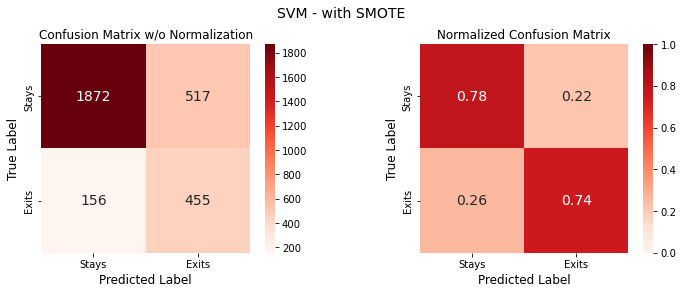

In [23]:
plot_conf_mat_w_and_wo_norm(loaded_models_svm, models_svm, 'svm_s', 'Reds')

As we noted earlier, using SMOTE gave us very good results. We have 74% true positives.

### Compare normalized confusion matrices

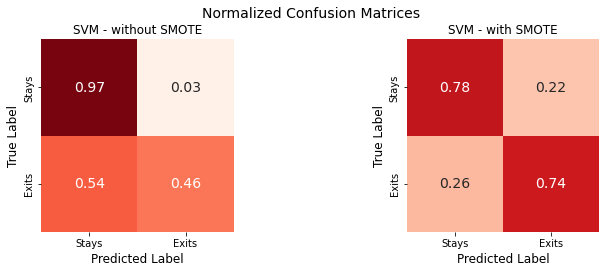

In [24]:
# Plot all confusion matrices 
plot_norm_conf_matrices(loaded_models_svm, models_svm, 'Reds')